# Testing PHD MCMC

## Imports

In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import corner
import phdmcmc

## Setting up

In [2]:
np.random.seed(42)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

In [3]:
def log_prior(theta, **kwargs):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.5 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0, theta
    return -np.inf, theta

In [4]:
def log_likelihood(theta, args=(), **kwargs):
    m, b, log_f = theta
    x, y, yerr = args
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2*log_f)
    return -0.5 * np.sum((y - model)**2 / sigma2 + np.log(sigma2))

In [5]:
pos = np.random.uniform((-5, 0.5, -10), (0.5, 10, 1), size=(100, 3)).astype(np.float32)
nwalkers, ndim = pos.shape

print("nwalkers: {}".format(nwalkers))
print("ndim: {}".format(ndim))
print(pos[0])

nwalkers: 100
ndim: 3
[-0.62853783  5.2750525  -3.6540573 ]


## MCMC run

In [6]:
full_acc, full_rej, full_probs, full_priors, n_acc = \
    phdmcmc.mcmc_mh(log_likelihood, log_prior, pos, args=(x, y, yerr), stepsize=0.05,
                    nwalkers=nwalkers, iterations=10000, verbose=4)
print("MCMC run completed.")

0 / 10000: 	 theta [   -inf    -inf    -inf] 	 logP      -inf 	 acceptance  45.00%
1000 / 10000: 	 theta [ -0.923   4.131  -0.750] 	 logP  -27.4540 	 acceptance  48.75%
2000 / 10000: 	 theta [ -0.802   3.584  -0.558] 	 logP  -27.1842 	 acceptance  47.82%
3000 / 10000: 	 theta [ -0.935   3.966  -0.790] 	 logP  -29.1185 	 acceptance  46.93%
4000 / 10000: 	 theta [ -0.959   4.315  -0.994] 	 logP  -30.9613 	 acceptance  46.22%
5000 / 10000: 	 theta [ -0.925   3.985  -0.661] 	 logP  -27.8580 	 acceptance  45.77%
6000 / 10000: 	 theta [ -0.922   4.157  -0.778] 	 logP  -27.8112 	 acceptance  45.35%
7000 / 10000: 	 theta [ -0.781   3.559  -0.532] 	 logP  -28.3232 	 acceptance  45.19%
8000 / 10000: 	 theta [ -0.907   3.991  -0.790] 	 logP  -27.4273 	 acceptance  44.99%
9000 / 10000: 	 theta [ -0.944   4.185  -0.747] 	 logP  -27.5921 	 acceptance  44.86%

MCMC run completed.


In [7]:
print("Accepted: {}".format(full_acc.shape))
print("Rejected: {}".format(full_rej.shape))
print("Likelihoods: {}".format(full_probs.shape))
print("Priors: {}".format(full_priors.shape))
# print("N accepted: {}".format(n_acc))

Accepted: (100, 10000, 3)
Rejected: (100, 10000, 3)
Likelihoods: (100, 10000)
Priors: (100, 10000)


In [8]:
acc, rej, probs, priors = phdmcmc.flat_chain(full_acc, full_rej, full_probs, full_priors, n_acc, discard=0.1)
print acc.shape, rej.shape

(403090, 3) (552174, 3)


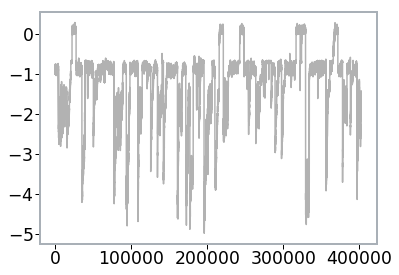

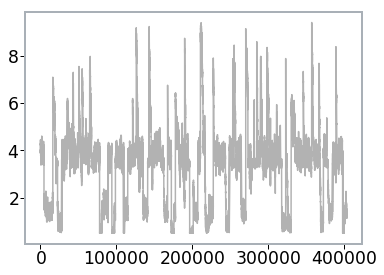

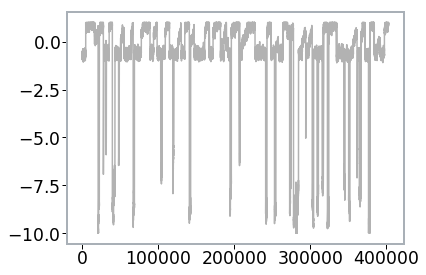

In [9]:
plt.plot(acc[:, 0], "k", alpha=0.3)
plt.show()
plt.plot(acc[:, 1], "k", alpha=0.3)
plt.show()
plt.plot(acc[:, 2], "k", alpha=0.3)
plt.show()

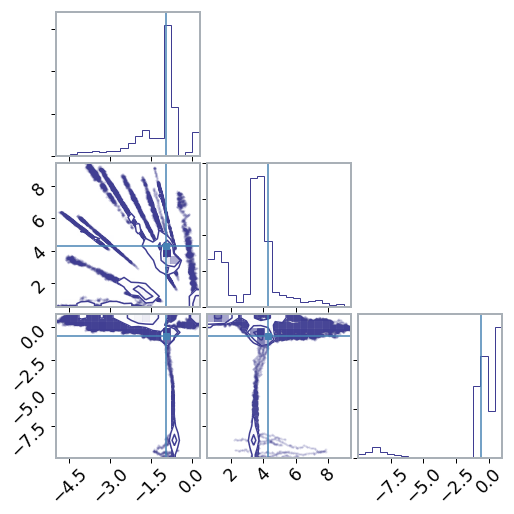

In [10]:
corner.corner(acc, color='#3F3D92', truths=[m_true, b_true, np.log(f_true)])
plt.show()

In [12]:
m_mcmc = np.percentile(acc[:, 0], [16, 50, 84])
b_mcmc = np.percentile(acc[:, 1], [16, 50, 84])
f_mcmc = np.percentile(np.exp(acc[:, 2]), [16, 50, 84])
q = [np.diff(m_mcmc), np.diff(b_mcmc), np.diff(f_mcmc)]

fmtstr = "| {:+2.4f} | {:+2.4f} / -{:1.4f} / +{:1.4f}"
print(fmtstr.format(m_true, m_mcmc[1], q[0][0], q[0][1]))
print(fmtstr.format(b_true, b_mcmc[1], q[1][0], q[1][1]))
print(fmtstr.format(f_true, f_mcmc[1], q[2][0], q[2][1]))

| -0.9594 | -0.9179 / -1.1349 / +0.2050
| +4.2940 | +3.5632 / -2.2333 / +0.7689
| +0.5340 | +0.6654 / -0.2071 / +1.6833
